In [9]:
import torch
import torch.nn as nn
import pennylane as qml
from pennylane import numpy as np
import lightning as L
import module_model
config = {}

In [10]:
class QuantumRotFCGNN(nn.Module):
    def __init__(self, num_ir_qubits, num_nr_qubits, num_layers, num_reupload, device="default.qubit", backend="ibmq_qasm_simulator", **kwargs):
        super().__init__()
        # rotation encoding on pennylane simulator
        def qml_encoding(_input, control_values):
            for i in range(num_nr_qubits):
                ctrl_H = qml.ctrl(qml.Hadamard, control=range(num_ir_qubits), control_values=control_values)
                ctrl_H(wires=num_ir_qubits+i)
                ctrl_R = qml.ctrl(qml.Rot, control=range(num_ir_qubits), control_values=control_values)
                ctrl_R(theta=_input[0], phi=_input[1], omega=_input[2], wires=num_ir_qubits+i)
        
        # rotation encoding on qiskit
        num_wk_qubits = num_ir_qubits - 1
        def qiskit_encoding(_input, control_values):
            theta, phi, omega = _input[0], _input[1], _input[2]
            # see N.C. page.184
            for i in range(num_nr_qubits):
                # control values
                for q in range(num_ir_qubits):
                    if control_values[q] == 0:
                        qml.PauliX(wires=q)
                # toffoli transformation
                if num_ir_qubits >= 2:
                    qml.Toffoli(wires=(0, 1, num_ir_qubits))
                for q in range(num_wk_qubits-1):
                    qml.Toffoli(wires=(2+q, num_ir_qubits+q, num_ir_qubits+1+q))
                # ctrl_H: decomposed by H = i Rx(pi) Ry(pi/2) (if complete graph with power of 2 nodes -> relative phase i becomes global)
                target_qubit = num_ir_qubits + num_wk_qubits + i
                qml.CRY(np.pi/2, wires=(num_ir_qubits + num_wk_qubits - 1, target_qubit))
                qml.CRX(np.pi, wires=(num_ir_qubits + num_wk_qubits - 1, target_qubit))
                # ctrl_R: Rot(phi, theta, omega) = Rz(omega) Ry(theta) Rz(phi)
                qml.CRZ(phi, wires=(num_ir_qubits + num_wk_qubits - 1, target_qubit))
                qml.CRY(theta, wires=(num_ir_qubits + num_wk_qubits - 1, target_qubit))
                qml.CRZ(omega, wires=(num_ir_qubits + num_wk_qubits - 1, target_qubit))
                # toffoli inverse transformation
                for q in reversed(range(num_wk_qubits-1)):
                    qml.Toffoli(wires=(2+q, num_ir_qubits+q, num_ir_qubits+1+q))
                if num_ir_qubits >= 2:
                    qml.Toffoli(wires=(0, 1, num_ir_qubits))
                # control values
                for q in range(num_ir_qubits):
                    if control_values[q] == 0:
                        qml.PauliX(wires=q)

        # constructing QCGNN like a MPGNN
        if "qiskit" in device or config["use_qiskit_enc"]:
            self.phi = module_model.QCGNN(num_ir_qubits, num_nr_qubits, num_layers, num_reupload, ctrl_enc=qiskit_encoding, device=device, backend=backend)
        else:
            self.phi = module_model.QCGNN(num_ir_qubits, num_nr_qubits, num_layers, num_reupload, ctrl_enc=qml_encoding, device=device)
        self.mlp = module_model.ClassicalMLP(in_channel=num_nr_qubits, out_channel=1, hidden_channel=0, num_layers=0)
    
    def forward(self, x):
        # inputs should be 1-dim for each data, otherwise it would be confused with batch shape
        x = torch.flatten(x, start_dim=-2, end_dim=-1)
        x = self.phi(x)
        x = self.mlp(x)
        return x

Global seed set to 0
Global seed set to 0


ModelLog: Quantum device  = default.qubit | Qubits (IR, WK, NR) = (4, 0, 3)
ModelLog: Quantum device  = default.qubit | Qubits (IR, WK, NR) = (4, 3, 3)
Pennylane = tensor([-2.8276, -2.2598, -3.7743,  3.4516, -5.1189,  8.9332,  1.2781, -1.3104,
         5.7688,  2.1649], grad_fn=<ReshapeAliasBackward0>)
Qiskit    = tensor([-2.8276, -2.2598, -3.7743,  3.4516, -5.1189,  8.9332,  1.2781, -1.3104,
         5.7688,  2.1649], grad_fn=<ReshapeAliasBackward0>)


(<Figure size 61900x1100 with 1 Axes>, <Axes: >)

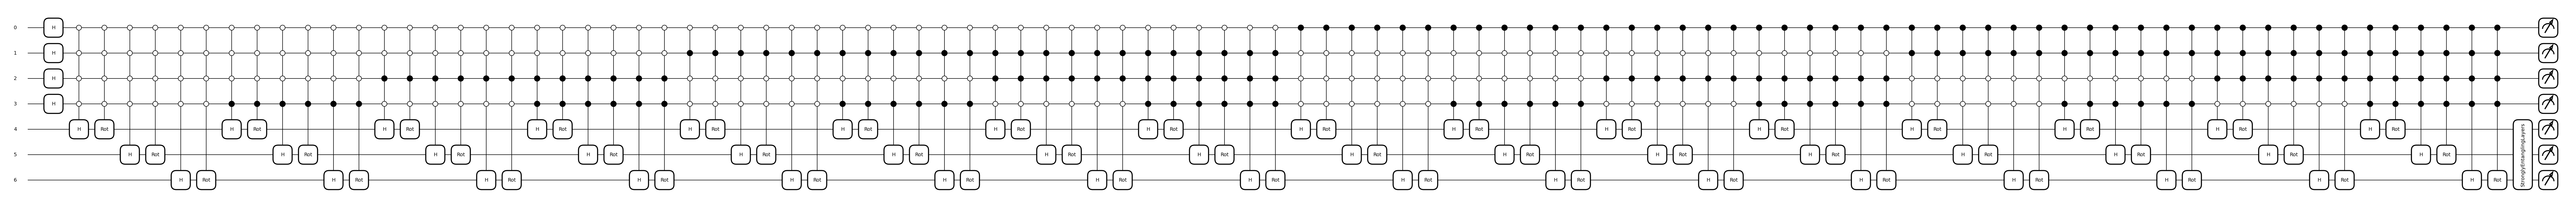

In [13]:
num_ir_qubits = 4
num_nr_qubits = 3

# Pennylane (including multi-control-qubit gate)
L.seed_everything(0)
config["use_qiskit_enc"] = False
model_qml = QuantumRotFCGNN(num_ir_qubits, num_nr_qubits, num_layers=1, num_reupload=0)

# Qiskit (all two-qubit gates)
L.seed_everything(0)
config["use_qiskit_enc"] = True
model_qiskit = QuantumRotFCGNN(num_ir_qubits, num_nr_qubits, num_layers=1, num_reupload=0)

x = torch.rand(10, 2**num_ir_qubits, 3)
print("Pennylane =", model_qml(x).reshape(-1))
print("Qiskit    =", model_qiskit(x).reshape(-1))
qml.draw_mpl(model_qml.phi.circuit)()
qml.draw_mpl(model_qiskit.phi.circuit)()